In [1]:
# Importing python EDA Package

import pandas as pd

In [2]:
# Hide warnings

import warnings
warnings.filterwarnings('ignore')

In [124]:
#Sometimes, cached files might cause issues. We can try clearing the cache of our package manager

#!pip cache purge

In [3]:
# Load cleaned dataset for modelling which is in the form of csv

tweets = pd.read_csv("FinalDataset.csv")

In [4]:
# Knowing the size of our dataset

tweets.shape

(117259, 10)

In [5]:
# Previewing first 5 records from the head

tweets.head()

,majority_target,followers_count,favourites,friends_count,statuses_count,mentions,replies,cred,tweet,sentiment
0,True,4262.0,10.0,3619.0,16423.0,1.0,1.0,0.540794,@RobertFosterMS To be clearI am tired of heari...,2.0
1,True,1393.0,1.0,1621.0,37184.0,3.0,0.0,0.462177,@oregonclematis And you look at what the progr...,2.0
2,True,9.0,0.0,84.0,1184.0,0.0,5.0,0.096774,@balrednirus @Aprapl @GriffinJesdes You forget...,1.0
3,True,4262.0,0.0,3619.0,16423.0,1.0,0.0,0.540794,@meliclem @killroy Forensic Audit Michigan ele...,1.0
4,True,70.0,1.0,166.0,2194.0,1.0,0.0,0.296610,@mukai Thx If we hold a stock amp the market c...,2.0


In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117259 entries, 0 to 117258
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   majority_target  117259 non-null  bool   
 1   followers_count  117259 non-null  float64
 2   favourites       117259 non-null  float64
 3   friends_count    117259 non-null  float64
 4   statuses_count   117259 non-null  float64
 5   mentions         117259 non-null  float64
 6   replies          117259 non-null  float64
 7   cred             117259 non-null  float64
 8   tweet            117259 non-null  object 
 9   sentiment        117259 non-null  float64
dtypes: bool(1), float64(8), object(1)
memory usage: 8.2+ MB


In [7]:
#Converting boolean attribute to int so that it will be easy to train models and interpret it

modelling_dataset = tweets
modelling_dataset['majority_target'] = modelling_dataset['majority_target'].apply(lambda x:int(x))

In [9]:
modelling_dataset.head()

,majority_target,followers_count,favourites,friends_count,statuses_count,mentions,replies,cred,tweet,sentiment
0,1,4262.0,10.0,3619.0,16423.0,1.0,1.0,0.540794,@RobertFosterMS To be clearI am tired of heari...,2.0
1,1,1393.0,1.0,1621.0,37184.0,3.0,0.0,0.462177,@oregonclematis And you look at what the progr...,2.0
2,1,9.0,0.0,84.0,1184.0,0.0,5.0,0.096774,@balrednirus @Aprapl @GriffinJesdes You forget...,1.0
3,1,4262.0,0.0,3619.0,16423.0,1.0,0.0,0.540794,@meliclem @killroy Forensic Audit Michigan ele...,1.0
4,1,70.0,1.0,166.0,2194.0,1.0,0.0,0.296610,@mukai Thx If we hold a stock amp the market c...,2.0


In [10]:
#Checking for target variable distribution across dataset

modelling_dataset['sentiment'].value_counts()

1.0    40454
0.0    38875
2.0    37930
Name: sentiment, dtype: int64

Feature Extraction

1. Bag of Words (BoW):

The Bag of Words model represents each document as a bag of individual words. It creates a vocabulary of unique words from the entire corpus and then converts each document into a fixed-length vector representing the frequency of each word in the vocabulary. This method is simple but can result in high-dimensional sparse vectors.

In [11]:
#Importing count vectorizer toconvert a collection of text documents to a vector of term/token counts

from sklearn.feature_extraction.text import CountVectorizer

In [13]:
def cVectorizer(data,attr):

    #Create the CountVectorizer object

    vectorizer = CountVectorizer()

    #Learn the vocabulary and assign indices to tweets words

    bow_matrix = vectorizer.fit_transform(data[attr])

    # Convert the sparse matrix to a DataFrame

    feature_df = pd.DataFrame.sparse.from_spmatrix(bow_matrix, columns=vectorizer.get_feature_names_out())
    altered_data = data.drop([attr,'sentiment'],axis=1)

    #Reset the indexes of the DataFrames
    df1_reset = altered_data.reset_index(drop=True)
    df2_reset = feature_df.reset_index(drop=True)

    # Merge the DataFrames based on their index
    merged_df = pd.concat([df1_reset, df2_reset], axis=1)

    return(merged_df)

In [14]:
#Importing libraries for model evaluation

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve

In [15]:
#Defining function for evaluating model

def EvaluateModel(model,X_test,y_test):

    # Make predictions
    y_pred = model.predict(X_test)

    try:
        # Calculate accuracy
        print("Accuracy:", accuracy_score(y_test, y_pred))
    except ValueError:
        return None


    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)/np.sum(confusion_matrix(y_test, y_pred))

    # Create the heatmap for confusion matrix using Seaborn
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Sentiment')
    plt.ylabel('Actual Sentiment')
    plt.show()

    try:
        # Get classification report
        print("Classification Report:\n",classification_report(y_test, y_pred))
    except ValueError:
        return None

    try:
        # Calculate the probabilities for each class
        y_prob = model.predict_proba(X_test)

        # Compute ROC curve and AUC for each class
        plt.figure()
        for class_index in range(model.classes_.shape[0]):
            fpr, tpr, _ = roc_curve(y_test, y_prob[:, class_index], pos_label=class_index)
            roc_auc = roc_auc_score(y_test == class_index, y_prob[:, class_index])

            plt.plot(fpr, tpr, lw=2, label='Class %d (AUC = %0.2f)' % (class_index, roc_auc))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves for All Classes')
        plt.legend(loc='lower right')
        plt.show()
    except AttributeError:
        return None

Modelling with all available Data

In [31]:
#Transforming the Dataset Using BoW, We will use just the 10000 of the records due to memory issue
#The sample will be same as the validation sample we used for our ideal model or base line model

bow_raw_data = cVectorizer(modelling_dataset[:10000],'tweet')

In [32]:
bow_raw_data.head()

,majority_target,followers_count,favourites,friends_count,statuses_count,mentions,replies,cred,aa,aaaaaaander,...,zsusk,zswhaley,zubymusic,zucker,zupahstar,zuspantrackguy,zyrkon,zzcouchgmailc,zzyzyx,zzzz
0,1,4262.0,10.0,3619.0,16423.0,1.0,1.0,0.540794,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1393.0,1.0,1621.0,37184.0,3.0,0.0,0.462177,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,9.0,0.0,84.0,1184.0,0.0,5.0,0.096774,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4262.0,0.0,3619.0,16423.0,1.0,0.0,0.540794,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,70.0,1.0,166.0,2194.0,1.0,0.0,0.296610,0,0,...,0,0,0,0,0,0,0,0,0,0


We will set 80% of our data for training and remaing 20% for testing. For hyper parameter tuning, we will use the validation data used before.

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(bow_raw_data, modelling_dataset['sentiment'][:10000], test_size=0.2, random_state=1)

Model 1 - Logistic Regression

In [24]:
#Importing library for logistic regression

from sklearn.linear_model import LogisticRegression

In [35]:
#Train the logistic regression model using the best hyperparameter from our ideal model

LRmodel = LogisticRegression(C=100)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=100)

Accuracy: 0.331


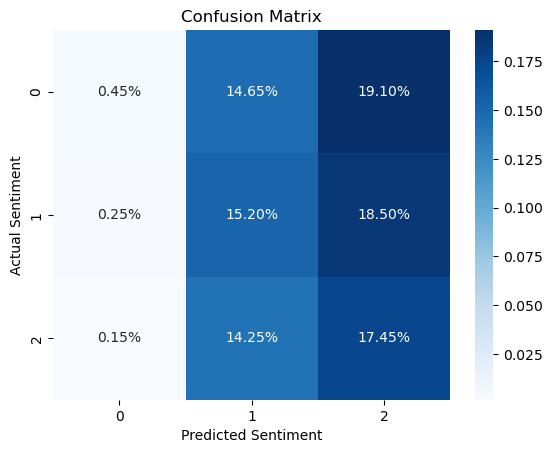

Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.01      0.03       684
         1.0       0.34      0.45      0.39       679
         2.0       0.32      0.55      0.40       637

    accuracy                           0.33      2000
   macro avg       0.40      0.34      0.27      2000
weighted avg       0.40      0.33      0.27      2000



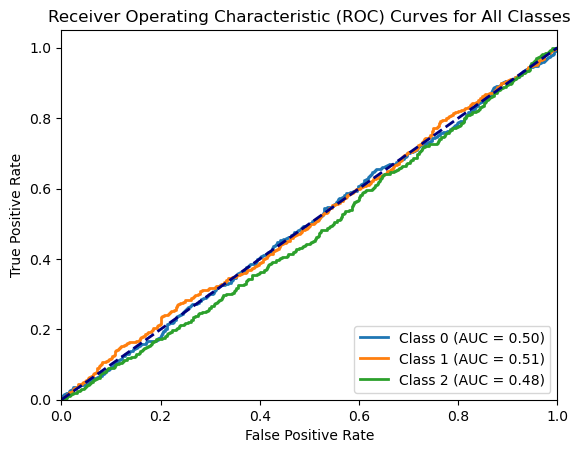

In [36]:
EvaluateModel(LRmodel,X_test,y_test)

The accuracy is very low, due to extra features we have used. This can be improved by preprocessing the other new features from meta data. We can control problems like having outliers. 

To know the optimal features for this new dataset, we will use random forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
# Train the LinearSVC model using the best hyperparameter

RFmodel = RandomForestClassifier(max_depth = 30, n_estimators = 150)
RFmodel.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=150)

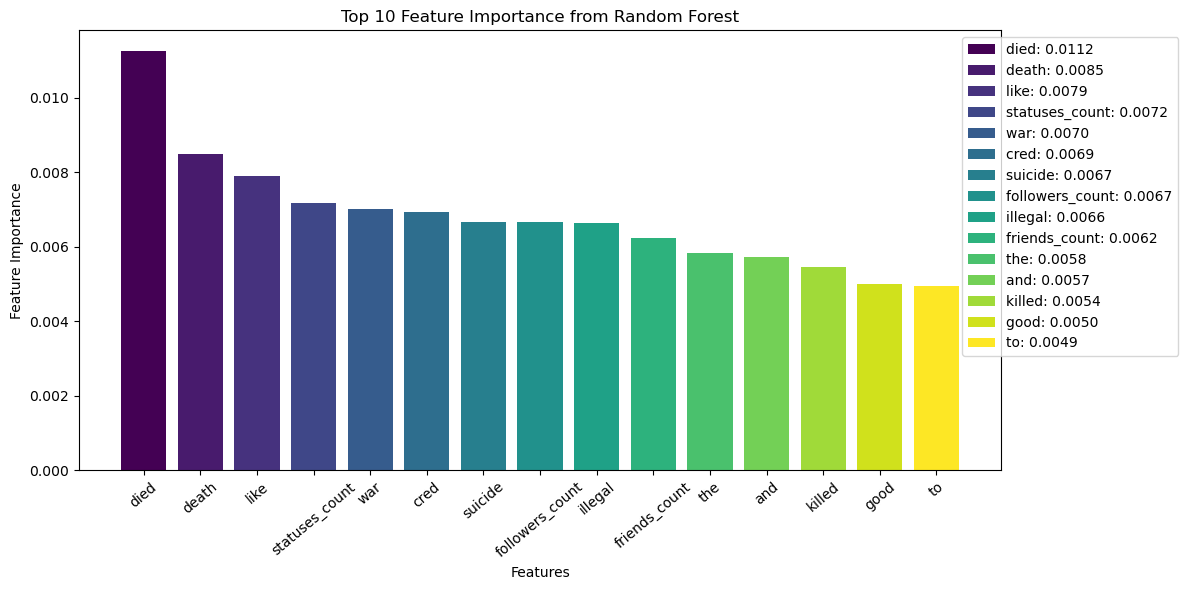

In [38]:
# Get feature importances from the trained Random Forest model
importances = RFmodel.feature_importances_
indices = np.argsort(importances)[::-1]

# Select the top 10 important features
top_features_indices = indices[:15]
top_features = X_train.columns[top_features_indices]

# Define colors for the bars
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

# Create the bar plot with different colors
plt.figure(figsize=(12, 6))
bars = plt.bar(top_features, importances[top_features_indices], color=colors)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Top 10 Feature Importance from Random Forest')
plt.xticks(rotation=40)

# Customize the color legend
legend_labels = [f'{feature}: {importance:.4f}' for feature, importance in zip(top_features, importances[top_features_indices])]
plt.legend(bars, legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()

# Show the plot
plt.show()

Further analysis to be continued with additonal feature pre-processing       ...............................................................................................